In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
import statsmodels.api as sm

price = pd.read_table('pricelist.csv',delimiter =';')
combi = pd.read_table('Historical_combi2.csv',delimiter =';')
I_2011 = pd.read_table('WTI_2014.csv',delimiter =';')

combi=combi.fillna(0)

In [2]:
I_2011

,Pred Year,Pred brent 2014,Pred FO 1% 2014,Pred FO 3.5% 2014,Pred Butane 2014,Pred VGO 0.5% 2014,TD 2014,Actual 2014,MD 2014
0,2008,75.0,-13.96,-21.85,-20.54,0.56,1.90,-5.7,1.30
1,2009,71.0,-13.27,-18.76,-18.89,-0.20,2.55,-5.7,1.87
2,2010,82.5,-8.44,-14.03,-21.56,0.98,3.14,-5.7,3.08
3,2011,100.0,1.37,-4.22,-17.94,12.34,2.40,-5.7,1.16
4,2012,100.0,-6.84,-11.13,-27.50,4.18,2.19,-5.7,-6.97
5,2013,100.0,-7.03,-12.15,-30.05,3.69,-1.36,-5.7,-8.56


In [3]:
import datetime
datetimes = [datetime.datetime.strptime(d, '%d.%m.%Y') for d in combi["Date"]]


df = pd.DataFrame(datetimes, columns=['date'])
df.loc[:, 'date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

combi = combi.assign(df=df['date'].values)
#print(combi)


/srv/conda/envs/notebook/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


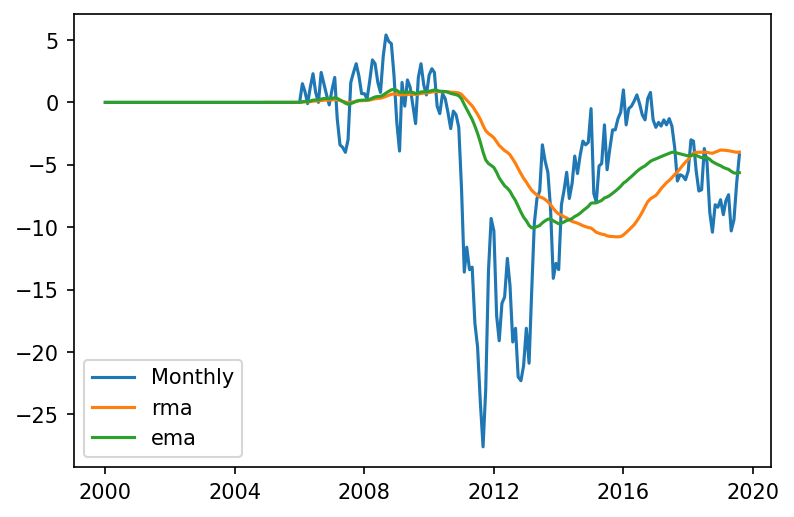

In [4]:
plt.rcParams['figure.dpi'] = 150

rma60 = combi["WTI"].rolling(window=60).mean()
ema60 = combi["WTI"].ewm(span=60, adjust=False).mean()
plt.plot(combi["df"],combi["WTI"])
plt.plot(combi["df"],rma60)
plt.plot(combi["df"],ema60)
plt.legend(("Monthly","rma","ema"))
plt.show()

combi = combi.assign(ema60=ema60.values)
combi = combi.assign(rma60=rma60.values)

In [5]:
ema=[combi[combi['df']=='2008-01-01']['ema60'].values,combi[combi['df']=='2009-01-01']['ema60'].values   \
     ,combi[combi['df']=='2010-01-01']['ema60'].values,combi[combi['df']=='2011-01-01']['ema60'].values  \
     ,combi[combi['df']=='2012-01-01']['ema60'].values,combi[combi['df']=='2013-01-01']['ema60'].values]
ema

[array([0.18839492]),
 array([0.95777029]),
 array([0.89093565]),
 array([0.28770832]),
 array([-5.21834226]),
 array([-9.48842736])]

In [6]:
rma=[combi[combi['df']=='2008-01-01']['rma60'].values,combi[combi['df']=='2009-01-01']['rma60'].values   \
     ,combi[combi['df']=='2010-01-01']['rma60'].values,combi[combi['df']=='2011-01-01']['rma60'].values  \
     ,combi[combi['df']=='2012-01-01']['rma60'].values,combi[combi['df']=='2013-01-01']['rma60'].values]
rma

[array([0.15333333]),
 array([0.655]),
 array([0.785]),
 array([0.64166667]),
 array([-2.83666667]),
 array([-6.39])]

In [7]:
X = combi[['Dated Brent','Butane','VGO 0.5%']]
Y = combi['WTI']
regr = linear_model.LinearRegression()
regr.fit(X, Y)
print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

DB= I_2011["Pred brent 2014"]
Bu= I_2011["Pred Butane 2014"]
VGO05= I_2011["Pred VGO 0.5% 2014"]
linear_WTI=regr.intercept_+ regr.coef_[0]*DB + regr.coef_[1]*Bu + regr.coef_[2]*VGO05
print(linear_WTI)

Intercept: 
 4.42565753993971
Coefficients: 
 [-0.11994083 -0.05832338 -0.60368246]
                            OLS Regression Results                            
Dep. Variable:                    WTI   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     62.47
Date:                Wed, 06 Nov 2019   Prob (F-statistic):           1.21e-29
Time:                        08:51:56   Log-Likelihood:                -691.04
No. Observations:                 236   AIC:                             1390.
Df Residuals:                     232   BIC:                             1404.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [8]:
nonlinear_WTI = -15.142388486653 - 2.06420352656404*Bu - 0.00877784990583735*DB*VGO05 - 0.000867998048676867*np.power(Bu,3) - 0.0803378779475392*np.power(Bu,2)
print(nonlinear_WTI)


0    0.515577
1    1.158719
2    0.007319
3   -9.786964
4   -4.749806
5   -5.344081
dtype: float64


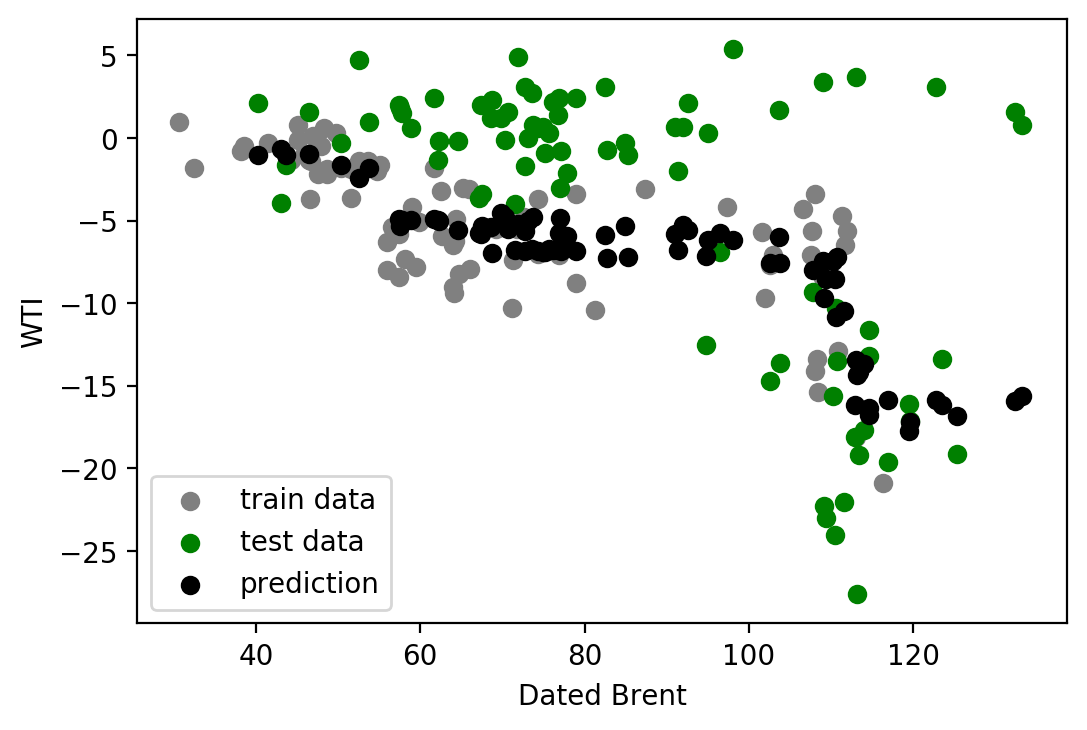

Mean squared error: 2.35
Feature ranking:
Feature Dated Brent (0.826687)
Feature Butane (0.085604)
Feature VGO 0.5% (0.087709)


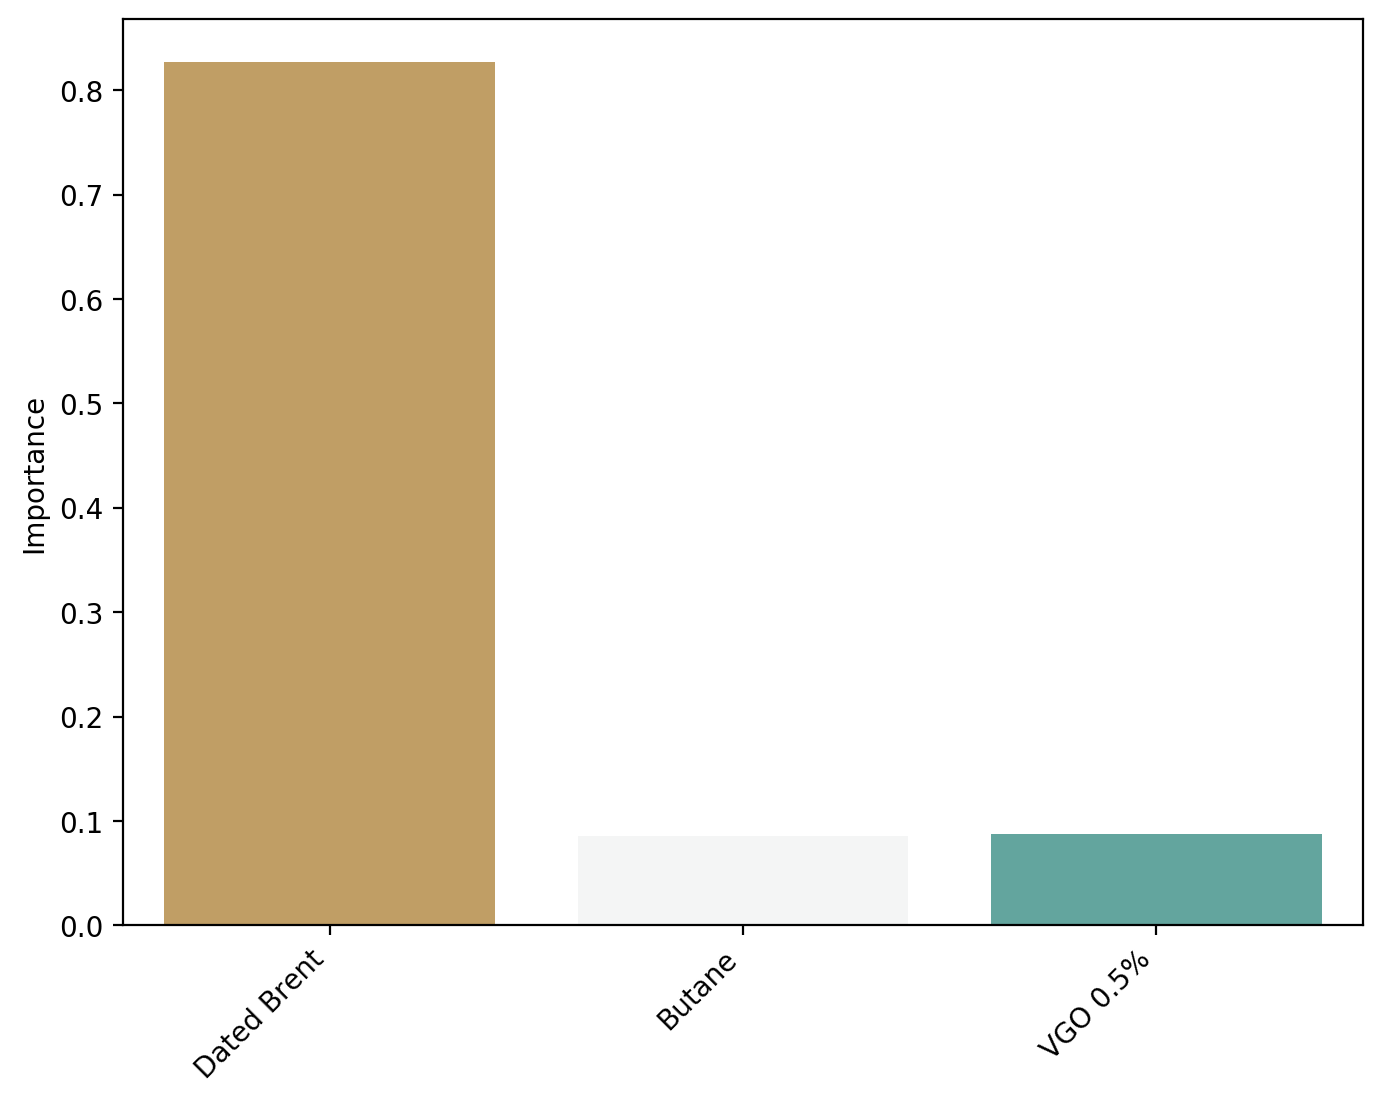

In [9]:
train_combi = combi.iloc[156:,1:]
test_combi = combi.iloc[75:155,1:]

plt.rcParams['figure.dpi'] = 200

#x_train=train_combi.drop("Maya Europe",axis=1)
#x_train=train_combi[train_combi.columns.difference(["Mars"])]
x_train=train_combi[["Dated Brent","Butane", "VGO 0.5%"]]
y_train=train_combi["WTI"]

#df.drop('b', axis=1)

#x_test=train_combi.drop("Maya Europe",axis=1)
#x_test=test_combi[test_combi.columns.difference(["Mars"])]
x_test=test_combi[["Dated Brent","Butane", "VGO 0.5%"]]
y_test=test_combi["WTI"].to_frame()



regressor = RandomForestRegressor(n_estimators=200, max_depth=5)

clf=regressor.fit(x_train, y_train)

y_pred=regressor.predict(x_test)
y_pred=pd.DataFrame(y_pred)


plt_train=plt.scatter(x_train["Dated Brent"],y_train,   color='grey')
plt_test=plt.scatter(x_test["Dated Brent"],y_test,   color='green')
plt_pred=plt.scatter(x_test["Dated Brent"], y_pred,  color='black')



plt.xlabel("Dated Brent")
plt.ylabel("WTI")
plt.legend((plt_train, plt_test,plt_pred),("train data", "test data","prediction"))
plt.show()

print("Mean squared error: %.2f"
      % np.mean((regressor.predict(x_train) - y_train) ** 2))

import seaborn as sns
importances=regressor.feature_importances_

indices=list(x_train)
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("Feature %s (%f)" % (indices[f], importances[f]))

f, (ax1) = plt.subplots(1, 1, figsize=(8, 6), sharex=True)
sns.barplot(indices, importances, palette="BrBG", ax=ax1)
ax1.set_ylabel("Importance")

ax1.set_xticklabels(
    ax1.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);




In [10]:
#data_df = price[['Dated brent','Butane','VGO 0.5%']]
data_df = pd.concat([DB, Bu,VGO05],axis=1)
y_pred=regressor.predict(data_df)
y_pred= pd.DataFrame(y_pred)
print(y_pred)

          0
0 -5.498243
1 -5.423728
2 -6.237671
3 -7.894643
4 -7.484307
5 -7.108670


MSE linear = 362.68
MSE non.linear = 215.79
MSE RF = 176.91


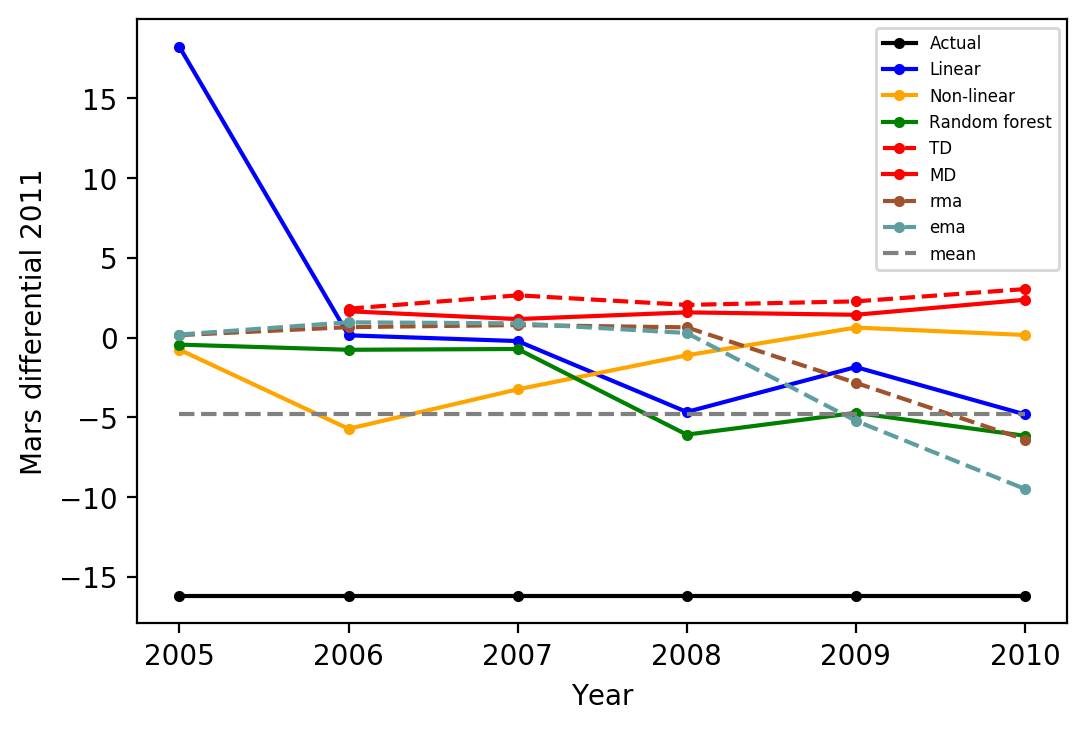

In [14]:
import pylab as plot
params = {'legend.fontsize': 6,
          'legend.handlelength': 2}
plot.rcParams.update(params)
plt.plot(I_2011["Pred Year"],I_2011["Actual 2011"],'k.-')
plt.plot(I_2011["Pred Year"],linear_WTI,'b.-')
plt.plot(I_2011["Pred Year"],nonlinear_WTI,'.-',color ='orange')
plt.plot(I_2011["Pred Year"],y_pred,'g.-')
plt.plot(I_2011["Pred Year"],I_2011["TD 2011"],'r.--')
plt.plot(I_2011["Pred Year"],I_2011["MD 2011"],'r.-')
plt.plot(I_2011["Pred Year"],rma,'.--',color ='sienna')
plt.plot(I_2011["Pred Year"],ema,'.--',color ='cadetblue')
plt.plot([I_2011["Pred Year"].iloc[0],I_2011["Pred Year"].iloc[-1]],[-4.8,-4.8],'--',color='grey')
plt.xlabel('Year')
plt.ylabel('Mars differential 2011')
plt.legend(("Actual","Linear","Non-linear","Random forest","TD","MD","rma","ema","mean"))

from sklearn.metrics import mean_squared_error 
mse_L = mean_squared_error(I_2011["Actual 2011"],linear_WTI)
mse_NL = mean_squared_error(I_2011["Actual 2011"],nonlinear_WTI)
mse_RF = mean_squared_error(I_2011["Actual 2011"],y_pred)

print('MSE linear =',"{0:.2f}".format(mse_L))
print('MSE non.linear =',"{0:.2f}".format(mse_NL))
print('MSE RF =',"{0:.2f}".format(mse_RF))


MSE linear = 201.36
MSE non.linear = 215.40
MSE RF = 169.22
MSE MD = 309.86


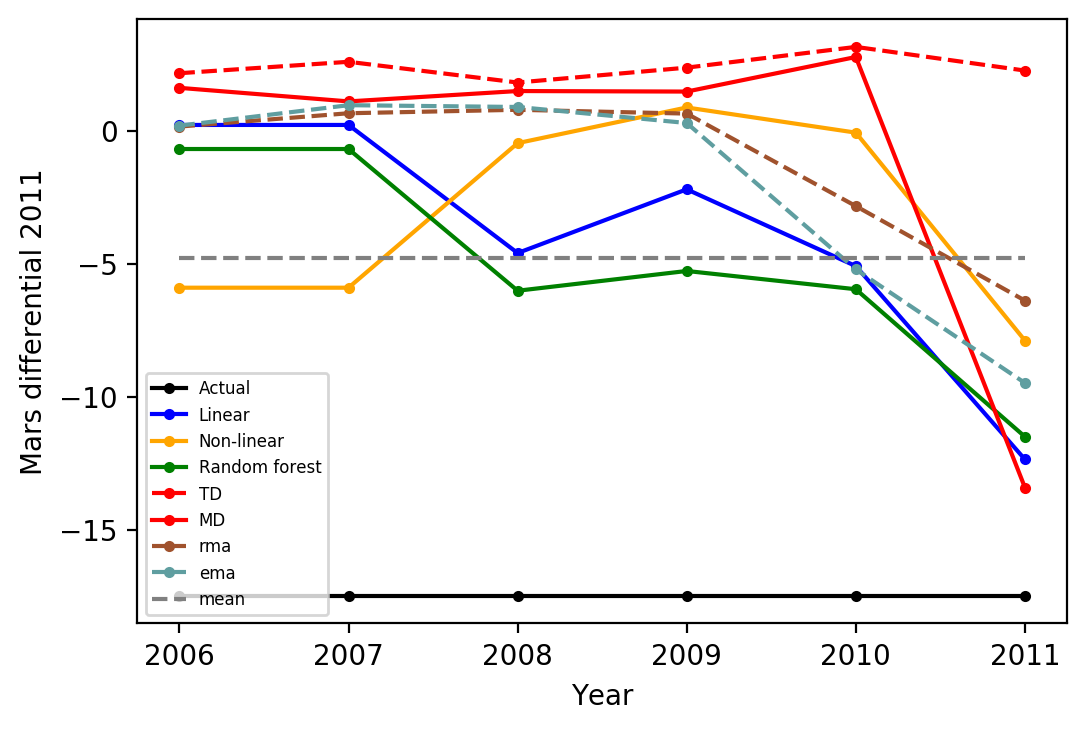

In [26]:
import pylab as plot
params = {'legend.fontsize': 6,
          'legend.handlelength': 2}
plot.rcParams.update(params)
plt.plot(I_2011["Pred Year"],I_2011["Actual 2012"],'k.-')
plt.plot(I_2011["Pred Year"],linear_WTI,'b.-')
plt.plot(I_2011["Pred Year"],nonlinear_WTI,'.-',color ='orange')
plt.plot(I_2011["Pred Year"],y_pred,'g.-')
plt.plot(I_2011["Pred Year"],I_2011["TD 2012"],'r.--')
plt.plot(I_2011["Pred Year"],I_2011["MD 2012"],'r.-')
plt.plot(I_2011["Pred Year"],rma,'.--',color ='sienna')
plt.plot(I_2011["Pred Year"],ema,'.--',color ='cadetblue')
plt.plot([I_2011["Pred Year"].iloc[0],I_2011["Pred Year"].iloc[-1]],[-4.8,-4.8],'--',color='grey')
plt.xlabel('Year')
plt.ylabel('Mars differential 2011')
plt.legend(("Actual","Linear","Non-linear","Random forest","TD","MD","rma","ema","mean"))

from sklearn.metrics import mean_squared_error 
mse_L = mean_squared_error(I_2011["Actual 2012"],linear_WTI)
mse_NL = mean_squared_error(I_2011["Actual 2012"],nonlinear_WTI)
mse_RF = mean_squared_error(I_2011["Actual 2012"],y_pred)
mse_MD = mean_squared_error(I_2011["Actual 2012"],I_2011["MD 2012"])

print('MSE linear =',"{0:.2f}".format(mse_L))
print('MSE non.linear =',"{0:.2f}".format(mse_NL))
print('MSE RF =',"{0:.2f}".format(mse_RF))
print('MSE MD =',"{0:.2f}".format(mse_MD))

MSE linear = 43.08
MSE non.linear = 68.64
MSE RF = 34.35
MSE MD = 112.58


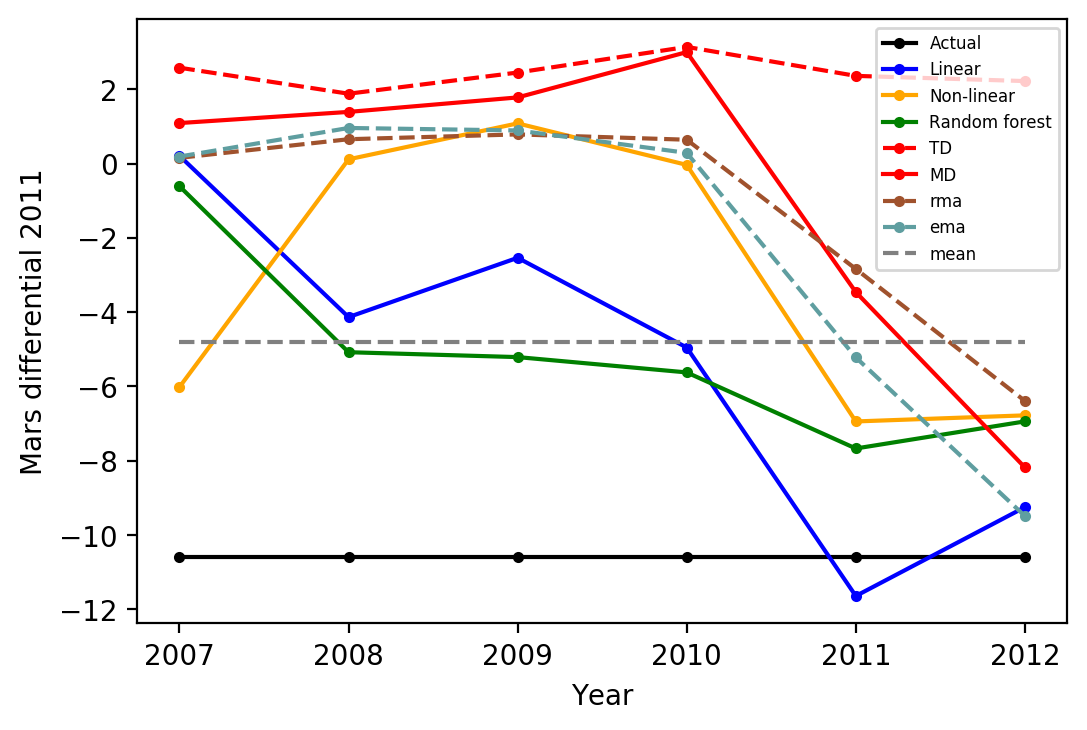

In [37]:
import pylab as plot
params = {'legend.fontsize': 6,
          'legend.handlelength': 2}
plot.rcParams.update(params)
plt.plot(I_2011["Pred Year"],I_2011["Actual 2013"],'k.-')
plt.plot(I_2011["Pred Year"],linear_WTI,'b.-')
plt.plot(I_2011["Pred Year"],nonlinear_WTI,'.-',color ='orange')
plt.plot(I_2011["Pred Year"],y_pred,'g.-')
plt.plot(I_2011["Pred Year"],I_2011["TD 2013"],'r.--')
plt.plot(I_2011["Pred Year"],I_2011["MD 2013"],'r.-')
plt.plot(I_2011["Pred Year"],rma,'.--',color ='sienna')
plt.plot(I_2011["Pred Year"],ema,'.--',color ='cadetblue')
plt.plot([I_2011["Pred Year"].iloc[0],I_2011["Pred Year"].iloc[-1]],[-4.8,-4.8],'--',color='grey')
plt.xlabel('Year')
plt.ylabel('Mars differential 2011')
plt.legend(("Actual","Linear","Non-linear","Random forest","TD","MD","rma","ema","mean"))

from sklearn.metrics import mean_squared_error 
mse_L = mean_squared_error(I_2011["Actual 2013"],linear_WTI)
mse_NL = mean_squared_error(I_2011["Actual 2013"],nonlinear_WTI)
mse_RF = mean_squared_error(I_2011["Actual 2013"],y_pred)
mse_MD = mean_squared_error(I_2011["Actual 2013"],I_2011["MD 2013"])

print('MSE linear =',"{0:.2f}".format(mse_L))
print('MSE non.linear =',"{0:.2f}".format(mse_NL))
print('MSE RF =',"{0:.2f}".format(mse_RF))
print('MSE MD =',"{0:.2f}".format(mse_MD))

MSE linear = 15.74
MSE non.linear = 22.66
MSE RF = 1.73
MSE MD = 40.04


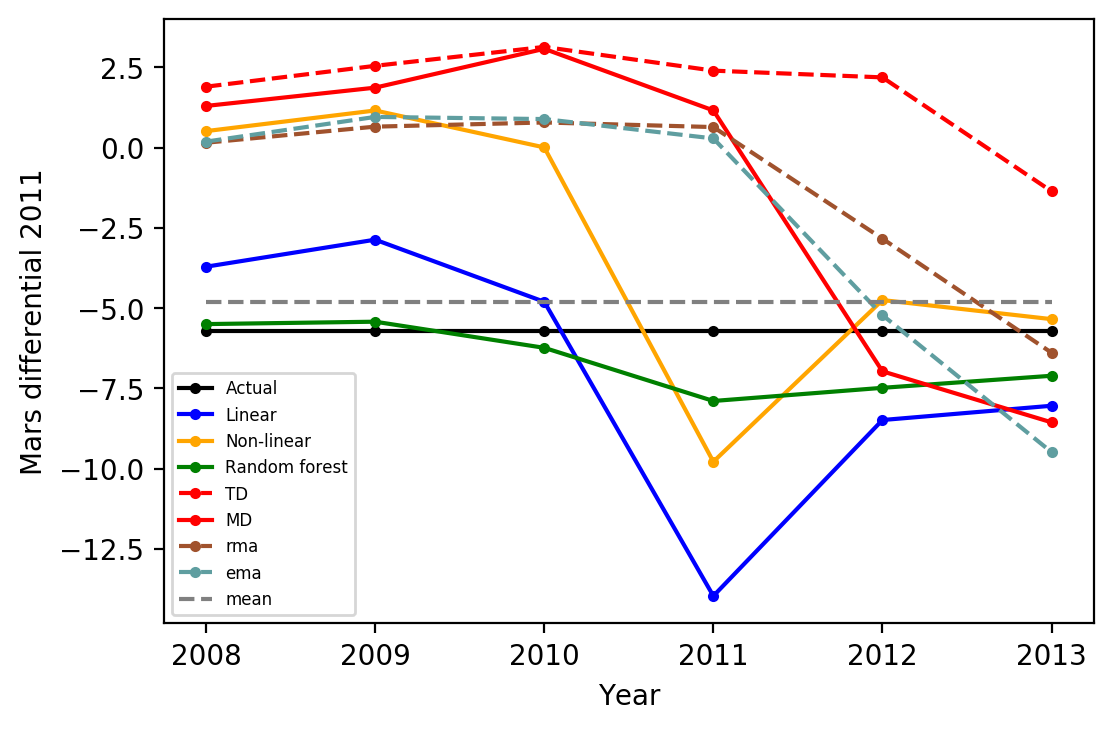

In [11]:
import pylab as plot
params = {'legend.fontsize': 6,
          'legend.handlelength': 2}
plot.rcParams.update(params)
plt.plot(I_2011["Pred Year"],I_2011["Actual 2014"],'k.-')
plt.plot(I_2011["Pred Year"],linear_WTI,'b.-')
plt.plot(I_2011["Pred Year"],nonlinear_WTI,'.-',color ='orange')
plt.plot(I_2011["Pred Year"],y_pred,'g.-')
plt.plot(I_2011["Pred Year"],I_2011["TD 2014"],'r.--')
plt.plot(I_2011["Pred Year"],I_2011["MD 2014"],'r.-')
plt.plot(I_2011["Pred Year"],rma,'.--',color ='sienna')
plt.plot(I_2011["Pred Year"],ema,'.--',color ='cadetblue')
plt.plot([I_2011["Pred Year"].iloc[0],I_2011["Pred Year"].iloc[-1]],[-4.8,-4.8],'--',color='grey')
plt.xlabel('Year')
plt.ylabel('Mars differential 2011')
plt.legend(("Actual","Linear","Non-linear","Random forest","TD","MD","rma","ema","mean"))

from sklearn.metrics import mean_squared_error 
mse_L = mean_squared_error(I_2011["Actual 2014"],linear_WTI)
mse_NL = mean_squared_error(I_2011["Actual 2014"],nonlinear_WTI)
mse_RF = mean_squared_error(I_2011["Actual 2014"],y_pred)
mse_MD = mean_squared_error(I_2011["Actual 2014"],I_2011["MD 2014"])

print('MSE linear =',"{0:.2f}".format(mse_L))
print('MSE non.linear =',"{0:.2f}".format(mse_NL))
print('MSE RF =',"{0:.2f}".format(mse_RF))
print('MSE MD =',"{0:.2f}".format(mse_MD))

In [52]:
I_2011

,Pred Year,Pred brent 2014,Pred FO 1% 2014,Pred FO 3.5% 2014,Pred Butane 2014,Pred VGO 0.5% 2014,TD 2014,Actual 2014,MD 2014
0,2008,75.0,-13.96,-21.85,-20.54,0.56,1.90,-5.7,1.30
1,2009,71.0,-13.27,-18.76,-18.89,-0.20,2.55,-5.7,1.87
2,2010,82.5,-8.44,-14.03,-21.56,0.98,3.14,-5.7,3.08
3,2011,100.0,1.37,-4.22,-17.94,12.34,2.40,-5.7,1.16
4,2012,100.0,-6.84,-11.13,-27.50,4.18,2.19,-5.7,-6.97
5,2013,100.0,-7.03,-12.15,-30.05,3.69,-1.36,-5.7,-8.56
